## Import Library dan Muat Dataset

memuat data awal dari file Excel dan menggabungkan data IB dan IK menjadi satu tabel.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from wordcloud import WordCloud

In [2]:
file_path = "dataset.xlsx"

ib_data = pd.read_excel(file_path, sheet_name="DATA IB")
ik_data = pd.read_excel(file_path, sheet_name="DATA IK")

# kolom yang relevan --> 'keperluan'
ib_data = ib_data[["desc"]].rename(columns={"desc": "keperluan"})
ik_data = ik_data[["tujuan"]].rename(columns={"tujuan": "keperluan"})

ib_data["izin"] = "IB"
ik_data["izin"] = "IK"

combined_data = pd.concat([ib_data, ik_data], ignore_index=True)

# Bersihkan teks pada kolom 'keperluan'
combined_data["keperluan"] = combined_data["keperluan"].str.strip().str.lower()

combined_data.to_csv("combined_ib_ik_keperluan.csv", index=False)

print(combined_data.head())

                 keperluan izin
0  ingin bertemu orang tua   IB
1  ingin bertemu orang tua   IB
2        libur akhir tahun   IB
3           libur semester   IB
4        bertemu orang tua   IB


## Exploratory Data Analysis (EDA)

Menganalisis informasi data yang telah digabungkan.

In [3]:
# Muat data
file_path = "combined_ib_ik_keperluan.csv"
data = pd.read_csv(file_path)

# Tampilkan informasi data
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80366 entries, 0 to 80365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keperluan  80366 non-null  object
 1   izin       80366 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None
                 keperluan izin
0  ingin bertemu orang tua   IB
1  ingin bertemu orang tua   IB
2        libur akhir tahun   IB
3           libur semester   IB
4        bertemu orang tua   IB


## Visualisasi Distribusi Kata pada Data "Keperluan"

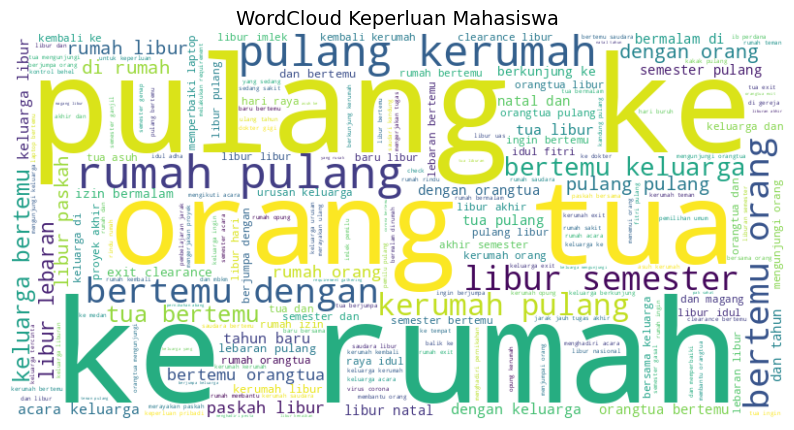

10 Kata Paling Umum dalam Keperluan:
pulang: 25158
rumah: 19215
ke: 18475
bertemu: 15071
libur: 14886
orang: 10994
tua: 10598
keluarga: 10439
kerumah: 9241
dan: 7372
dengan: 5415
semester: 4958
orangtua: 4349
di: 3142
lebaran: 2484
paskah: 2433
acara: 2111
tahun: 1919
bermalam: 1719
natal: 1713


In [4]:
# Hitung distribusi kata
all_keperluan = " ".join(data["keperluan"])
word_counts = Counter(all_keperluan.split())

# Tampilkan WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_keperluan)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Keperluan Mahasiswa", fontsize=14)
plt.show()

# Tampilkan kata paling umum
common_words = word_counts.most_common(20)
print("10 Kata Paling Umum dalam Keperluan:")
for word, count in common_words:
    print(f"{word}: {count}")


## Klasifikasi Data Berdasarkan Aturan

Mengklasifikasikan data kolom keperluan menjadi beberapa kategori menggunakan aturan berbasis regex.

In [5]:
# Klasifikasi keperluan
def classify_keperluan(text):
    if re.search(r"(laptop|printer|buku|barang)", text):
        return "Membeli Barang"
    elif re.search(r"(orangtua|orang tua|keluarga|saudara|pulang|rumah|bertemu|libur|pemilu|ib|pesta|pernikahan|natal|lebaran|paskah|acara|izin bermalam)", text):
        return "Bertemu Keluarga"
    elif re.search(r"(proyek|PKM|tugas|makalah|requirement|observasi|pa 1|pa 2| pa 3|tugas akhir|akhir)", text):
        return "Tugas Kuliah"
    elif re.search(r"(kontrol|gigi|behel|cabut|sakit|berobat)", text):
        return "Pergi ke Klinik"
    elif re.search(r"(atm|rekening|tabungan|kartu)", text):
        return "Mengurus Kartu Bank"
    elif re.search(r"(exit|clearance|wisuda)", text):
        return "Tamat Kuliah"
    else:
        return "Lainnya"

data["kategori"] = data["keperluan"].apply(classify_keperluan)


print(data["kategori"].value_counts())

data.to_csv("categorized_keperluan.csv", index=False)


kategori
Bertemu Keluarga       70672
Lainnya                 5440
Tamat Kuliah            1225
Pergi ke Klinik         1006
Membeli Barang           936
Tugas Kuliah             930
Mengurus Kartu Bank      157
Name: count, dtype: int64


In [6]:
opp_data = pd.read_csv("categorized_keperluan.csv")
opp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80366 entries, 0 to 80365
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keperluan  80366 non-null  object
 1   izin       80366 non-null  object
 2   kategori   80366 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


## Label Encoding

Konversi kategori menjadi nilai numerik.

In [7]:
# Encode kategori menjadi nilai numerik
label_encoder = LabelEncoder()
opp_data["kategori_encoded"] = label_encoder.fit_transform(opp_data["kategori"])

print("Data Setelah Encoding:")
print(opp_data[["keperluan", "kategori", "kategori_encoded"]])

Data Setelah Encoding:
                                               keperluan          kategori  \
0                                ingin bertemu orang tua  Bertemu Keluarga   
1                                ingin bertemu orang tua  Bertemu Keluarga   
2                                      libur akhir tahun  Bertemu Keluarga   
3                                         libur semester  Bertemu Keluarga   
4                                      bertemu orang tua  Bertemu Keluarga   
...                                                  ...               ...   
80361                                       keperluan pa           Lainnya   
80362          lebih cepat pulang untuk melakukan pemilu  Bertemu Keluarga   
80363  melakukan requirement ke sd mutiara balige unt...      Tugas Kuliah   
80364                      ingin persiapan pulang pemilu  Bertemu Keluarga   
80365                 urusan keluarga , melayat keluarga  Bertemu Keluarga   

       kategori_encoded  
0             

In [8]:
# Representasi teks menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(opp_data["keperluan"]).toarray()

print("TF-IDF Features (Sampel):")
print(X[:2])  # Contoh 2 baris pertama untuk melihat hasil transformasi

TF-IDF Features (Sampel):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
# Fitur (X) dan target (y)
y = opp_data["kategori_encoded"]

# Split data ke dalam train-test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Ukuran Train: {X_train.shape}, Ukuran Test: {X_test.shape}")

Ukuran Train: (56256, 2389), Ukuran Test: (24110, 2389)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Inisialisasi model
rf_model = RandomForestClassifier(random_state=42)

# Latih model
rf_model.fit(X_train, y_train)

# Prediksi pada test set
rf_predictions = rf_model.predict(X_test)

# Evaluasi performa
print("Random Forest Classifier Report:")
print(classification_report(y_test, rf_predictions))
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21244
           1       0.99      1.00      0.99      1599
           2       1.00      0.99      0.99       254
           3       0.96      0.89      0.92        55
           4       1.00      1.00      1.00       308
           5       1.00      1.00      1.00       359
           6       0.98      0.96      0.97       291

    accuracy                           1.00     24110
   macro avg       0.99      0.98      0.98     24110
weighted avg       1.00      1.00      1.00     24110

Accuracy: 1.00


In [11]:
from sklearn.linear_model import LogisticRegression

# Inisialisasi model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Latih model
lr_model.fit(X_train, y_train)

# Prediksi pada test set
lr_predictions = lr_model.predict(X_test)

# Evaluasi performa
print("Logistic Regression Report:")
print(classification_report(y_test, lr_predictions))
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.2f}")


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21244
           1       0.98      1.00      0.99      1599
           2       1.00      0.98      0.99       254
           3       0.96      0.80      0.87        55
           4       1.00      0.98      0.99       308
           5       0.98      1.00      0.99       359
           6       0.99      0.93      0.96       291

    accuracy                           1.00     24110
   macro avg       0.99      0.96      0.97     24110
weighted avg       1.00      1.00      1.00     24110

Accuracy: 1.00


In [12]:
from sklearn.model_selection import GridSearchCV

# Parameter untuk tuning
rf_params = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": ['sqrt', 'log2']
}

# GridSearch
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring="accuracy")
rf_grid.fit(X_train, y_train)

print("Best Random Forest Params:", rf_grid.best_params_)
print(f"Best Accuracy: {rf_grid.best_score_:.2f}")


Best Random Forest Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150}
Best Accuracy: 1.00


In [ ]:
# Parameter untuk tuning
lr_params = {
    "penalty":['l1','l2','elasticnet','none'],
    "C": [0.1, 1, 10],
    "solver": ['lbfgs','newton-cg','liblinear','sag','saga'],
    "max_iter"  : [100,1000,2500,5000]
}

# GridSearch
lr_grid = GridSearchCV(lr_model, lr_params, cv=3, scoring="accuracy")
lr_grid.fit(X_train, y_train)

print("Best Logistic Regression Params:", lr_grid.best_params_)
print(f"Best Accuracy: {lr_grid.best_score_:.2f}")


In [12]:
from sklearn.pipeline import Pipeline

# Pipeline Random Forest
rf_pipeline = Pipeline([
    ("rf", RandomForestClassifier(**rf_grid.best_params_, random_state=42))
])

# Pipeline Logistic Regression
lr_pipeline = Pipeline([
    ("lr", LogisticRegression(**lr_grid.best_params_, random_state=42, max_iter=1000))
])

# Latih ulang pipeline
rf_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)


Pipeline(steps=[('lr',
                 LogisticRegression(C=10, max_iter=1000, random_state=42))])

In [13]:
# Evaluasi Random Forest
rf_final_predictions = rf_pipeline.predict(X_test)
rf_final_accuracy = accuracy_score(y_test, rf_final_predictions)
print(f"Final Random Forest Accuracy: {rf_final_accuracy:.2f}")

# Evaluasi Logistic Regression
lr_final_predictions = lr_pipeline.predict(X_test)
lr_final_accuracy = accuracy_score(y_test, lr_final_predictions)
print(f"Final Logistic Regression Accuracy: {lr_final_accuracy:.2f}")


Final Random Forest Accuracy: 1.00
Final Logistic Regression Accuracy: 1.00


In [14]:
# Prediksi kategori untuk teks baru
new_texts = [
    "Pulang kerumah keluarga besar untuk Lebaran",
    "Membeli laptop baru untuk tugas kuliah",
    "Pergi ke rumah sakit untuk kontrol kesehatan"
]

# Fungsi klasifikasi menggunakan aturan sebelumnya
def classify_new_texts(texts):
    predicted_categories = []
    for text in texts:
        if re.search(r"(laptop|printer|buku|barang)", text):
            predicted_categories.append("Membeli Barang")
        elif re.search(r"(orangtua|orang tua|keluarga|saudara|pulang|rumah|bertemu|libur|pemilu|ib|pesta|pernikahan|natal|lebaran|paskah|acara|izin bermalam)", text):
            predicted_categories.append("Bertemu Keluarga")
        elif re.search(r"(proyek|PKM|tugas|makalah|requirement|observasi|pa 1|pa 2| pa 3|tugas akhir|akhir)", text):
            predicted_categories.append("Tugas Kuliah")
        elif re.search(r"(kontrol|gigi|behel|cabut|sakit|berobat)", text):
            predicted_categories.append("Pergi ke Klinik")
        elif re.search(r"(atm|rekening|tabungan|kartu)", text):
            predicted_categories.append("Mengurus Kartu Bank")
        elif re.search(r"(exit|clearance|wisuda)", text):
            predicted_categories.append("Tamat Kuliah")
        else:
            predicted_categories.append("Lainnya")
    return predicted_categories

# Klasifikasi menggunakan aturan
classified_texts = classify_new_texts(new_texts)
print("Classified Texts:", classified_texts)

# Convert kategori ke encoding numerik untuk prediksi model
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
opp_data["kategori_encoded"] = label_encoder.fit_transform(opp_data["kategori"])  # Pastikan ini telah dilakukan sebelumnya
new_text_encoded = label_encoder.transform(classified_texts)

# Prediksi menggunakan Random Forest
rf_predictions = rf_pipeline.predict(new_text_encoded.reshape(-1, 1))
rf_predictions_decoded = label_encoder.inverse_transform(rf_predictions)
print("Random Forest Predictions:", rf_predictions_decoded)

# Prediksi menggunakan Logistic Regression
lr_predictions = lr_pipeline.predict(new_text_encoded.reshape(-1, 1))
lr_predictions_decoded = label_encoder.inverse_transform(lr_predictions)
print("Logistic Regression Predictions:", lr_predictions_decoded)

# Map predictions to opportunities
opportunities = {
    "Membeli Barang": "Promosi produk elektronik dan alat tulis",
    "Bertemu Keluarga": "Penawaran tiket liburan atau transportasi",
    "Tugas Kuliah": "Layanan printing dan material akademik",
    "Pergi ke Klinik": "Paket layanan kesehatan",
    "Mengurus Kartu Bank": "Layanan pengelolaan keuangan mahasiswa",
    "Tamat Kuliah": "Dukungan karir dan sertifikasi tambahan",
    "Lainnya": "Layanan umum untuk kebutuhan mahasiswa"
}

print("Recommended Services:")
for category in rf_predictions_decoded:
    print(f"Category: {category} --> {opportunities.get(category, 'Tidak Ada Peluang')}")


Classified Texts: ['Bertemu Keluarga', 'Membeli Barang', 'Bertemu Keluarga']
Random Forest Predictions: ['Bertemu Keluarga' 'Membeli Barang' 'Bertemu Keluarga']
Logistic Regression Predictions: ['Bertemu Keluarga' 'Membeli Barang' 'Bertemu Keluarga']
Recommended Services:
Category: Bertemu Keluarga --> Penawaran tiket liburan atau transportasi
Category: Membeli Barang --> Promosi produk elektronik dan alat tulis
Category: Bertemu Keluarga --> Penawaran tiket liburan atau transportasi


/home/ownsys/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/ownsys/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
